<a href="https://colab.research.google.com/github/AndreaCamilloni/dd2412-deep-learning-uncertainty-estimation/blob/main/Uncertainty_Estimation_Aleatoric_Uncertainty_and_Simple_VI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertainty Estimation with Probabilistic Discriminative Deep Networks

In this implementation exercise, we understand the notions of aleatoric and epistemic uncertainties and practice modelling such uncertainties for simple deep networks.

## Introduction
In standard discriminative modelling, we try to learn the parameters $\mathbf{\theta}$ of a deep network $f_{\mathbf{\theta}}:\mathcal{X}\rightarrow \mathcal{Y}$ that maps an input $x\in\mathcal{X}=\mathbb{R}^d$ to its corresponding output $\hat{y}=f_{\mathbf{\theta}}(\mathbf{x})\in\mathcal{Y}$. The parameters $\theta \in \mathbb{R}^p$ are trained on a training set of $n$ samples $\mathcal{D}=\{(\mathbf{x}_i, y_i)\}_{i=1}^{n}$

Uncertainty estimation is concerned with reflecting a *degree of confidence* with a deep network's prediction. That is, instead of directly mapping the input $\mathbf{x}$ to the corresponding prediction $\hat{y}$, it maps it to a distribution over possible outputs $\hat{P}(y|\mathbf{x})$.

In this implementation practical, we first create a toy dataset and then try simple techniques to model two main types of uncertainties: *aleatoric* and *epistemic*.

## Types of Uncertainty 
**Aleatoric uncertainty**, also known as irreducable uncertainty, refers to the inherent uncertainty that are present in the observations $(\mathbf{x},y)$. For instance, the measurements (*e.g.,* length of a tool) can be noisy depending on the precision of the measuring device (*e.g.*, a ruler with one-centimeter markings). This type of uncertainty cannot be remedied by better modelling or additional data, hence the adjective "irreducible". Aleatoric uncertainty can be either *homoscedastic* and *heteroscedastic*. Homoscedastic aleatoric uncertainty does not depend on a sample $\mathbf{x}$ (*e.g.*, the length of a tool can always have a fixed error of up to one centimeter) while a heteroscedastic aleatoric uncertainty can change depending on the sample (*e.g.*, a depth camera might give more error on certain surfaces than others depending on the material of the surface and reflectance and illuminance properties).  

**Epistemic uncertainty**, also known as knowledge uncertainty,  is induced by a model's lack of (enough) knowledge about a certain sample to make a confident prediction on it. As such, epistemic uncertainty is always heteroscedastic *i.e.*, sample-dependent. Knowledge uncertainty is sometimes further divided into seprate *model* and *distributional* uncertainties reflecting the uncertainty induced by the inability of modeling and lack of enough data respectively. As such, epistemic uncertainty can be tackled by either improving the modelling or increasing the dataset size.

We will use a few simple methods, described in the lectures, to tackle these uncertainties by using 

i) Maximum Likelihood Estimation (MLE) of aleatoric uncertainty, and 

ii) Variational Inference (VI)-based Bayesian deep networks for epistemic uncertainty.

But let's first create a toy dataset.


In [ ]:
#@title Import the necessary libraries for creating the data (numpy) and plotting it
import numpy as np
import matplotlib.pyplot as plt
import tqdm


%matplotlib inline

np.random.seed(1)

# Toy Regression Dataset Creation 

## Introduction
In this exercise the goal is to familiarize the students with basic concepts of deep probabilistic modelling. As such, we create and use a toy dataset since it will 1) allow us to put more emphasis on the pedagogical aspect of the practical, 2) it will make visualizing the important concepts easier, and 3) reduce the computational load necessary for the analysis.

## Underlying Function
For this first toy dataset, we consider a one-dimensional regression task $\mathcal{X}=\mathbb{R}\rightarrow\mathcal{Y}=\mathbb{R}$. The underlying true function is the periodic even cosine function $y=\text{cos}(x)$. Modelling a periodic function can be generally challenging for a deep network. 

## Basic Clean Training Set
For the basic clean training set $\mathcal{D}$, we create $n=200$ samples with $x\in[-1.3\pi,1.3\pi]$ and store them in the following variables.

```
# X_train       # training points input
# Y_train_true  # training points clean label
```



In [ ]:
#@title define a function to sample from the true distribution
def sample_cosine(n_samples,
                  domain,
                  gaussian_noise_std=None,
                  heteroscedastic_noise_fun=None):
    assert gaussian_noise_std is None or heteroscedastic_noise_fun is None,\
        "Either gaussian_noise_std and heteroscedastic_noise_fun can be provided"
    # we assume that the samples are uniformly distributed
    x = np.linspace(domain[0],
                    domain[1],
                    n_samples).reshape(-1, 1)

    if gaussian_noise_std is None and heteroscedastic_noise_fun is None:
        y = np.cos(x)
    else:
        gaussian_noise = np.random.randn(n_samples, 1)
        if heteroscedastic_noise_fun is None:
            y = np.cos(x) + gaussian_noise * gaussian_noise_std
        else:
            y = np.cos(x)
            y = y + heteroscedastic_noise_fun(gaussian_noise,x,y)
        
    return x,y

In [ ]:
n_train = 100
domain_train= np.pi * np.array([-1.3, 1.3])
X_train, Y_train_true = sample_cosine(n_train,
                                      domain_train)

let's visually inspect our clean training data

In [ ]:
#@title Define a function for visualization
def visualize_samples(samples_list,ux,uy,domain_visualization,title, figsize=(15, 4)):
    fig = plt.figure(figsize=figsize)
    for x_samples,y_samples,kwargs in samples_list:
        plt.scatter(x_samples, y_samples,**kwargs)

    plt.plot(ux, uy, linewidth=3, label='Underlying Function')
    plt.xlim(domain_visualization)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.grid()

In [ ]:
#@title Sample at a higher resolution for visualization of the true function
domain_visualization = np.pi * np.array([-3.2, 3.2])
visualization_resolution = 1000
ux, uy = sample_cosine(visualization_resolution,
                       domain_visualization)

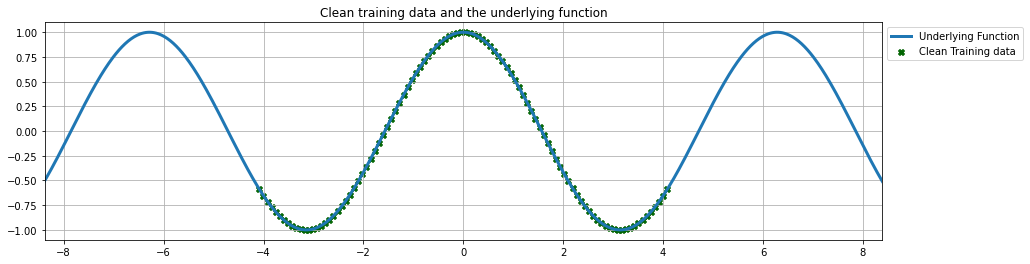

In [ ]:
#@title Visualize training data
visualization_train_kwargs = {'marker':'X',
                              'linewidth':1,
                              'color':'darkgreen', 
                              'label':'Clean Training data'}
visualize_samples_list = [(X_train,
                           Y_train_true,
                           visualization_train_kwargs)]
zooming_factor=1.2
visualize_samples(visualize_samples_list,
                  ux,
                  uy,
                  domain_visualization/zooming_factor,
                  title='Clean training data and the underlying function')

so, the training data densely covers the interval $-1.3\pi, 1.3\pi$.

## Basic Clean Test Set
Now let's create a test set that covers inputs beyond the observed interval during training. For the basic clean test set $\mathcal{D}_{test}$, we create $n_{test}=200$ samples with $x\in[-3\pi,3\pi]$ and store them in the following variables.

```
# X_test       # test points input
# Y_test_true  # test points clean label
```

In [ ]:
n_test = 200
domain_test = np.pi * np.array([-3, 3])
X_test, Y_test_true = sample_cosine(n_test,
                                    domain_test)

let's visually inspect our clean test and training data

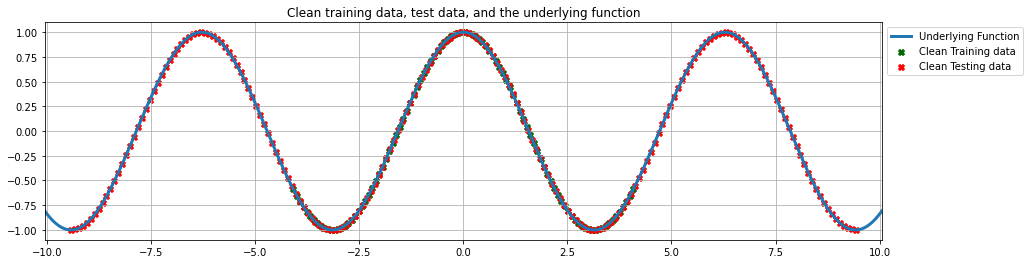

In [ ]:
visualization_test_kwargs={'marker':'X',
                           'linewidth':1, 
                           'color':'red', 
                           'label':'Clean Testing data'}
# update visualization list
visualize_samples_list.append(
    (X_test,
     Y_test_true,
     visualization_test_kwargs))
visualize_samples(visualize_samples_list,
                  ux,
                  uy, 
                  domain_visualization,
                  title='Clean training data, test data, and the underlying function')

## Homoscedastic Gaussian Noise on the Training Set
Datasets are commonly noisy due to various reasons, for instance because of the measurement errors. So, a more realistic dataset will contain some noise in the labels. We will first create a dataset containing *homoscedastic* label noise -- a noise independent of the sample. For this, we choose an additive Gaussian noise $\mathcal{N}(0,\sigma^2)$ with variance $\sigma^2=0.01$. We call the dataset with the homoscedastic noise $\mathcal{D}^{homo}$. It contains the same input samples as that of $\mathcal{D}$ but the corresponding labels $y$ are generated with additive gaussian noise and stored in the following variable.

```
# Y_train_homo  # training points label with homoscedastic additive Gaussiannoise
```

In [ ]:
noise_std = 0.1
# sample again with noise
X_train, Y_train_hom = sample_cosine(n_train,
                                     domain_train,
                                     gaussian_noise_std=noise_std)

Now, let us visualize the training data with homoscedastic label noise this time.

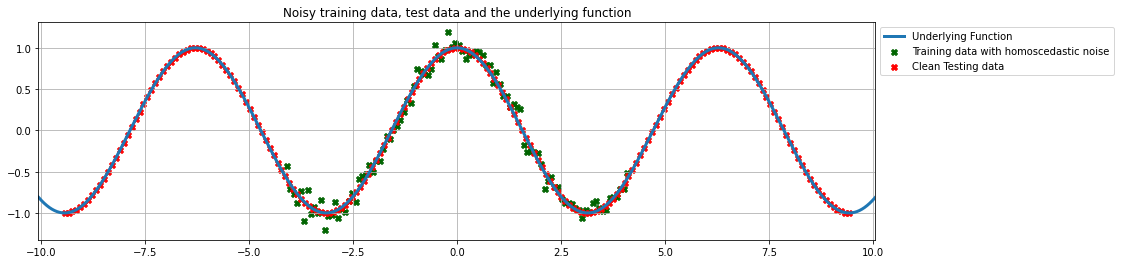

In [ ]:
# update visualization information
visualization_train_kwargs['label']='Training data with homoscedastic noise'
visualize_samples_list[0]=(X_train,
                           Y_train_hom,
                           visualization_train_kwargs)
visualize_samples(visualize_samples_list,
                  ux,
                  uy, 
                  domain_visualization,
                  title='Noisy training data, test data and the underlying function')

## Heteroscedastic Noise on the Training Set
We then create another dataset, but this time, containing *heteroscedastic* label noise -- a noise that is dependent on the sample. It is common for the label noise to be dependent on the magnitude for continuous labels. For this reason, we choose a *multiplicative* Gaussian noise $\mathcal{N}(\mu,\sigma^2)$ with mean $\mu=1$ and variance $\sigma^2=0.01$. We call the dataset with the heteroscedastic noise $\mathcal{D}^{het}$. It contains the same input samples as that of $\mathcal{D}$ but the corresponding labels $y$ are generated with multiplicative gaussian noise and stored in the following variable.

```
# Y_train_het  # training points label with homoscedastic additive Gaussiannoise
```

In [ ]:
noise_std = 0.2
noise_mean = 0
noise_fun = lambda noise,x,y: noise_std * noise * y + noise_mean
X_train, Y_train_het = sample_cosine(n_train,
                                     domain_train,
                                     heteroscedastic_noise_fun=noise_fun)

Now, let us visualize the training data with heteroscedastic label noise this time.

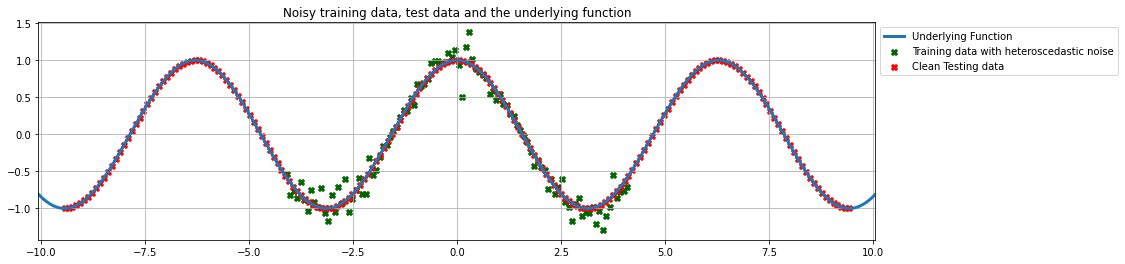

In [ ]:
# update visualization information
visualization_train_kwargs['label']='Training data with heteroscedastic noise'
visualize_samples_list[0]=(X_train,
                           Y_train_het,
                           visualization_train_kwargs)
visualize_samples(visualize_samples_list,
                  ux,
                  uy, 
                  domain_visualization,
                  title='Noisy training data, test data and the underlying function')

# Regularized Risk Minimization

In a regularized risk minimization scheme, we train a model parametrized by $\mathbf{\theta}$, on a training set $\mathcal{D}=\{(x_i,y_i)\}_{i=1}^{n}$, using the following minimization:
\begin{align}
\mathbf{\theta}^*=\text{argmin}_{\mathbf{\theta}} \mathcal{L}(\mathcal{D}) + \Omega(\mathbf{\theta}) = \text{argmin}_{\mathbf{\theta}}\sum_{i=1}^{n}l(f_\theta(x_i), y_i) + \Omega(\mathbf{\theta}), \tag{1}
\end{align}

where $\mathcal{L}$ is the total loss function operating on the who;e training set, $l$ is the sample loss function operating on individual training pairs $(x_i,y_i)$ and $\Omega$ is a regularization cost function.

## Training a Multi-Layer Perceptron (MLP)
Initially, we train a MLP, also known as fully-connected network, parametrized by its weights and biases $\mathbf{\theta}$. We use three hidden layers of size 100,20,100 units and the Rectified Linear Unit (ReLU), $\max(0,h)$, as the activation function. We adopt mean squared error as the loss function and weight decay as the regularization technique. Throughout this practical, we use Jax as the framework to implement our deep networks.

### Jax Deep Learning Framework
Jax uses a standard python (Numpy) implementation for describing a model's operations and enables GPU-optimized and differentible training using XLA and Autograd respectively. A simple tutorial can be found on the project page: https://github.com/google/jax. 

Let us first import the necessary Jax libraries.

In [ ]:
import time

import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax import nn
from jax.example_libraries import optimizers

from functools import partial

# initialize the random generator 
key = random.PRNGKey(1)

Next, we define the configuration of the fully-connected (FC) network:

In [ ]:
# standard network's configurations
input_dim = X_train.shape[1]
output_dim = Y_train_true.shape[1]
layers_width = [100, 20, 100]
num_epochs = 1000
step_size = 1e-2

Now, we define two python functions; one for initializing the parameters of a FC *layer* and another for the feed-forward computation of a FC *layer*.

In [ ]:
# Initialize the parameters of a standard fully-connected layer 
def standard_fc_layer_init(input_dim, output_dim, key, scale=1e-2):
    keys = random.split(key, 2)
    weights = random.normal(keys[0], (output_dim, input_dim)) * scale
    biases  = random.normal(keys[1], (output_dim, 1)) * scale
    return weights, biases

In [ ]:
# Forward pass of a standard fully-connected layer 
def standard_fc_layer_forward(input, weights, biases):
    return jnp.dot(weights, input) + biases

Next, we define two python functions; one for initializing the parameters of a FC *network* and another for the feed-forward computation of a FC *network*.

In [ ]:
# Initialize A standard fully-connected network 
def standard_fc_network_init(input_dim, layers_width, output_dim, key):
    network_feature_dims = [input_dim, *layers_width, output_dim]
    number_of_layers = len(network_feature_dims[:-1])
    keys = random.split(key, number_of_layers)
    params = [standard_fc_layer_init(network_feature_dims[i],
                                    network_feature_dims[i+1],
                                    keys[i]) 
                for i in range(number_of_layers)]
    return params

In [ ]:
# Forward pass of a standard fully-connected network 
def standard_fc_network_forward(input, params, is_classification=False):
    representation = input
    for weights,biases in params[:-1]:
        representation = nn.relu(standard_fc_layer_forward(representation, weights, biases))
    representation = standard_fc_layer_forward(representation,params[-1][0], params[-1][1])

    if is_classification:
        logits = representation - nn.logsumexp(representation)
        return logits
    
    return representation

In the following, we define a python function corresponding to the mean squared error (MSE) loss, as 

\begin{align}
\mathcal{L}(\mathcal{D})=\sum_{i=1}^{n}l(f_\theta(x_i),y_i)=\sum_{i=1}^{n}(f_\theta(x_i)-y_i)^2
\end{align}

In [ ]:
def loss_mse(params, X, Y):
    """ Compute the MSE loss """
    preds = standard_fc_network_forward(X, params)
    return jnp.mean(jnp.power(preds[0,:] - Y, 2))

Finally, we implement the code necessary for optimizing the network's parameters using the training data.

In [ ]:
# Compute the gradient for a batch and update the parameters 
@partial(jit, static_argnums=(4,))
def update(params, X, Y, opt_state, loss):
    value, grads = value_and_grad(loss)(params, X, Y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [ ]:
# Implements a learning loop over epochs. 
def run_training_loop(num_epochs, opt_state, X, Y, X_test, Y_test, num_layers, loss):
    # Initialize placeholder for logging
    train_loss, train_mse, test_mse = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial loss after random init
    train_loss.append(loss(params, X.T, Y.T))
    train_mse.append(loss_mse(params[:num_layers], X.T, Y.T))
    test_mse.append(loss_mse(params[:num_layers], X_test.T, Y_test.T))
    print('Starting loss: ', train_loss[-1], ' Starting mse: ', train_mse[-1])

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        params, opt_state, loss_val = update(params, X.T, Y.T, opt_state, loss)

        epoch_time = time.time() - start_time
        test_mse.append(loss_mse(params[:num_layers], X_test.T, Y_test.T))
        train_loss.append(loss(params, X.T, Y.T))
        train_mse.append(loss_mse(params[:num_layers], X.T, Y.T))
        if epoch%200 == 0:
            print("Epoch {} | T: {:0.6f} | Train loss:"
                  " {:0.3f} | Train mse: {:0.3f} | Test mse:"
                  " {:0.3f}".format(epoch+1, 
                                    epoch_time,
                                    train_loss[-1], 
                                    train_mse[-1], 
                                    test_mse[-1]))

    return params, train_loss, train_mse, test_mse

In [ ]:
def visulize_predictions(Y_test_pred, title_text, X_train=[], Y_train=[], sigma_param=-1):
    fig = plt.figure(figsize=(15, 4))
    ux = np.pi * np.linspace(-3, 3, 1000).reshape(-1, 1)
    uy = np.cos(ux)
    plt.plot(ux, uy, linewidth=3, label='Underlying Function')
    plt.plot(X_test, Y_test_pred.T, linewidth=3, color='red', label='Prediction on Testing Points')
    axes = plt.gca()
    axes.set_ylim([-1.5,1.5])
    if not jnp.isscalar(sigma_param) or sigma_param >= 0:
        plt.fill_between(X_test.ravel(), 
                        (Y_test_pred + 2 * sigma_param).ravel(), 
                        (Y_test_pred - 2 * sigma_param).ravel(), 
                        alpha=0.3, label='Epistemic uncertainty')
        plt.scatter(X_train, 
                    Y_train, 
                    marker='X', 
                    linewidth=1, 
                    color='darkgreen',
                    label='Clean Training data')
    plt.title(title_text)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.grid()

Finally, let us launch the training for the clean dataset and visualize the learnt function.

In [ ]:
# Initialize the network parameters
params = standard_fc_network_init(input_dim,
                                  layers_width,
                                  output_dim,
                                  key)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

params,\
train_loss,\
train_mse,\
test_mse = run_training_loop(num_epochs, 
                             opt_state, 
                             X_train,
                             Y_train_true,
                             X_test, 
                             Y_test_true,
                             len(layers_width)+1, 
                             loss_mse)

Starting loss:  0.5547592  Starting mse:  0.5547592
Epoch 1 | T: 0.823072 | Train loss: 0.548 | Train mse: 0.548 | Test mse: 0.503
Epoch 201 | T: 0.000458 | Train loss: 0.000 | Train mse: 0.000 | Test mse: 0.656
Epoch 401 | T: 0.000463 | Train loss: 0.000 | Train mse: 0.000 | Test mse: 1.037
Epoch 601 | T: 0.000461 | Train loss: 0.000 | Train mse: 0.000 | Test mse: 1.230
Epoch 801 | T: 0.000468 | Train loss: 0.000 | Train mse: 0.000 | Test mse: 1.408


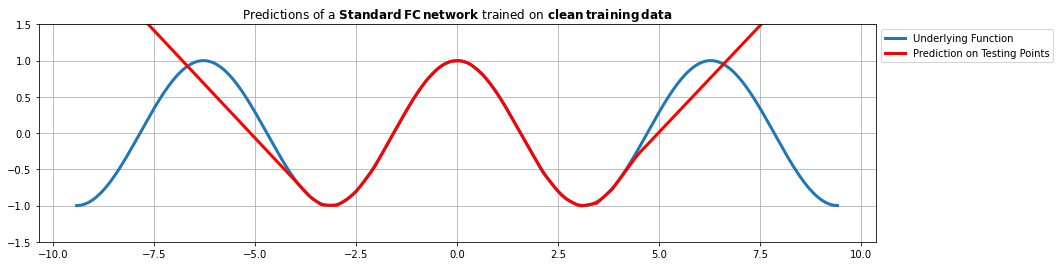

In [ ]:
Y_test_pred = standard_fc_network_forward(X_test.T, params)
visulize_predictions(Y_test_pred, 
                     r'Predictions of a $\bf{Standard\, FC\, network}$'
                     r' trained on $\bf{clean\, training\, data}$')

We get a great match in the training range $[-1.3\pi,1.3\pi]$ while the predictions become outside this range which is understandable due to the hardness of generalizing to periodic functions after only observing one period.

Now, let's train and test on the training data with homoscedastic noise

In [ ]:
# Initialize the network parameters
params_hom = standard_fc_network_init(input_dim,
                                      layers_width,
                                      output_dim, 
                                      key)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params_hom)

params_hom,\
train_loss_hom,\
train_mse_hom,\
test_mse_hom = run_training_loop(num_epochs, 
                                 opt_state, 
                                 X_train, 
                                 Y_train_hom,
                                 X_test, 
                                 Y_test_true, 
                                 len(layers_width)+1, 
                                 loss_mse)

Starting loss:  0.57258314  Starting mse:  0.57258314
Epoch 1 | T: 0.001102 | Train loss: 0.566 | Train mse: 0.566 | Test mse: 0.503
Epoch 201 | T: 0.000491 | Train loss: 0.007 | Train mse: 0.007 | Test mse: 0.583
Epoch 401 | T: 0.000456 | Train loss: 0.007 | Train mse: 0.007 | Test mse: 0.722
Epoch 601 | T: 0.000458 | Train loss: 0.006 | Train mse: 0.006 | Test mse: 0.711
Epoch 801 | T: 0.000518 | Train loss: 0.006 | Train mse: 0.006 | Test mse: 0.688


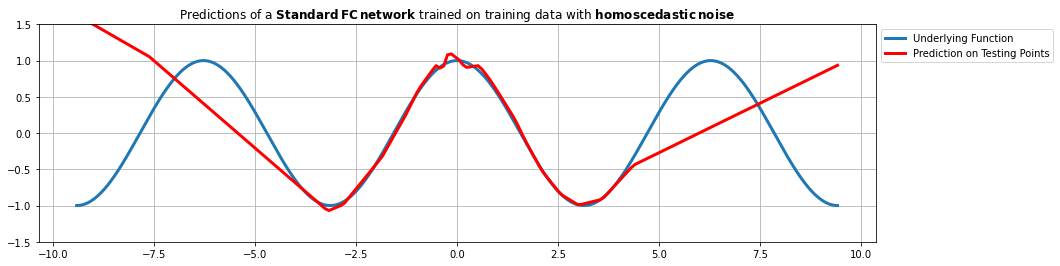

In [ ]:
Y_test_pred_hom = standard_fc_network_forward(X_test.T, params_hom)
visulize_predictions(Y_test_pred_hom, 
                     r'Predictions of a $\bf{Standard\, FC\, network}$'
                     r' trained on training data with $\bf{homoscedastic\, noise}$')

We can see that the network overfits to some of the noise present in the training data.

Let us go the dataset exhibiting heteroscedastic label noise next: 

In [ ]:
# Initialize the network parameters
params_het = standard_fc_network_init(input_dim, 
                                      layers_width, 
                                      output_dim, 
                                      key)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params_het)

params_het,\
train_loss_het,\
train_mse_het,\
test_mse_het = run_training_loop(num_epochs, 
                                 opt_state, 
                                 X_train, 
                                 Y_train_het, 
                                 X_test, 
                                 Y_test_true, 
                                 len(layers_width)+1, 
                                 loss_mse)

Starting loss:  0.60294235  Starting mse:  0.60294235
Epoch 1 | T: 0.001527 | Train loss: 0.596 | Train mse: 0.596 | Test mse: 0.503
Epoch 201 | T: 0.000436 | Train loss: 0.017 | Train mse: 0.017 | Test mse: 0.533
Epoch 401 | T: 0.000453 | Train loss: 0.015 | Train mse: 0.015 | Test mse: 0.825
Epoch 601 | T: 0.000496 | Train loss: 0.014 | Train mse: 0.014 | Test mse: 1.297
Epoch 801 | T: 0.000479 | Train loss: 0.014 | Train mse: 0.014 | Test mse: 1.634


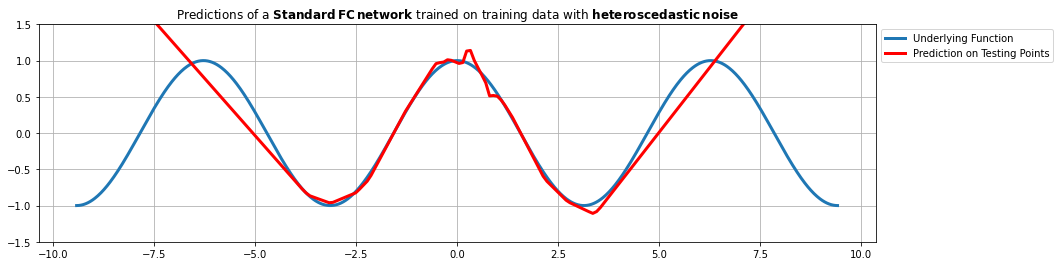

In [ ]:
Y_test_pred_het = standard_fc_network_forward(X_test.T, 
                                              params_het)
visulize_predictions(Y_test_pred_het,
                     r'Predictions of a $\bf{Standard\, FC\, network}$'
                     r' trained on training data with $\bf{heteroscedastic\, noise}$')

Here we see that the network heavily overfits to most of the heteroscedastic noise present in the training data.

# Training with Assuming a Label Noise Distribution

In the class, we discussed that one way to model aleatoric uncertainty is using maximum likelihood estimation (MLE) in tandem with a model that can output probability distributions. Here, we are going to follow this idea to see how well this approach can predict the aleatoric uncertainty.

## Modelling Aleatoric Uncertainty: Learning to predict a fixed (homoscedastic) uncertainty
For a maximum likelihood estimation we need to devise a likelihood function. Let's assume a Gaussian likelihood function, parametrized by a deep network to give its mean and variance, given an input. In this first part, we assume the deep network produces a fixed variance independent of the input sample while the mean is dependent on the input sample. That is, our likelihood function has the following form:

\begin{align}
P(y|\mathbf{x};\mathbf{\theta}) = \mathcal{N}(\mu=f_{\mathbf{\theta}}(\mathbf{x}),\sigma^2=f'_\theta).
\end{align}

First, we consider an additional parameter for the fixed variance and initialize the rest of the network parameters as before.

In [ ]:
# assume one scalar for the fixed standard dev of the likelihood's Gaussian
sigma_param = jnp.array(jnp.log(0.2))

# Initialize the network parameters that will produce the mean of the likelihood's Gaussian
params_homo_model_clean_data = standard_fc_network_init(input_dim,
                                                        layers_width, 
                                                        output_dim, 
                                                        key)

# add the likelihood's Gaussian's standard dev to the list of parameters
params_homo_model_clean_data.append(sigma_param)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params_homo_model_clean_data)

Then, we would like to find $\theta$ that maximizes the likelihood of our observed data:

\begin{align}
\mathbf{\theta}^*=\text{argmax}_\mathbf{\theta}\prod_{i=1}^{n}P(y_i|\mathbf{x}_i;\mathbf{\theta}).
\end{align}

Taking the log and plugging in the Normal distributions we get:

\begin{align}
\mathbf{\theta}^*=\text{argmax}_\mathbf{\theta}\sum_{i=1}^{n}\log \mathcal{N}(\mu=f_{\mathbf{\theta}}(\mathbf{x}_i),\sigma^2=f'_\theta)|_{y_i}= \text{argmin}_\mathbf{\theta}[...]
\end{align}

**========================**
####**TODO**: Complete Equations.
**========================**



Your job is now to fill in the missing part above and implement the corresponding loss function. Note that the last term is an *argmin*.

In [ ]:
def loss_mle_homoscedastic(params, X, Y):
    """
    ==============================
    TODO: Implementation required.
    ==============================
    1. Assume params[-1] contains the natural logarithm of the standard_deviation
    2. Return the total loss calculated as you derived above.
    """
    preds = standard_fc_network_forward(X, params[:-1])
    
    # raise NotImplementedError("Task: Implement!")
    # loss = jnp.mean(jnp.power(preds[0,:] - Y, 2)) / params[-1]**2
    loss = jnp.mean(jnp.log(jnp.sqrt(2 * jnp.pi)) + params[-1]+ ((preds - Y) ** 2) / (2 * jnp.exp(params[-1]) ** 2))
    return loss

Starting loss:  6.2439904  Starting mse:  0.5547592
Epoch 1 | T: 0.636204 | Train loss: 6.038 | Train mse: 0.548 | Test mse: 0.503
Epoch 201 | T: 0.000519 | Train loss: -0.709 | Train mse: 0.000 | Test mse: 0.869
Epoch 401 | T: 0.000538 | Train loss: -1.324 | Train mse: 0.000 | Test mse: 1.526
Epoch 601 | T: 0.000499 | Train loss: -1.795 | Train mse: 0.001 | Test mse: 1.879
Epoch 801 | T: 0.000594 | Train loss: -2.433 | Train mse: 0.000 | Test mse: 1.879
The final trained homoscedastic standard deviation for clean data is:  0.02180588


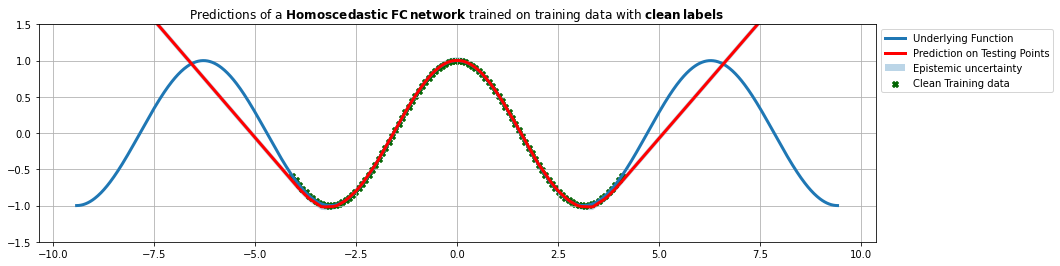

In [ ]:
params_homo_model_clean_data,\
train_loss_homo_model_clean_data,\
train_mse_homo_model_clean_data,\
test_mse_homo_model_clean_data = run_training_loop(num_epochs, 
                                                   opt_state, X_train, 
                                                   Y_train_true, X_test, 
                                                   Y_test_true, 
                                                   len(layers_width)+1, 
                                                   loss_mle_homoscedastic)

sigma_param = jnp.exp(params_homo_model_clean_data[-1])
print('The final trained homoscedastic standard deviation'
      ' for clean data is: ', 
      sigma_param)

Y_test_pred_homo_model_clean_data = standard_fc_network_forward(X_test.T,
                                                                params_homo_model_clean_data[:-1])

visulize_predictions(Y_test_pred_homo_model_clean_data,  
                     r'Predictions of a $\bf{Homoscedastic\, FC\, network}$'
                     r' trained on training data with $\bf{clean\, labels}$', 
                     X_train, 
                     Y_train_true, 
                     sigma_param)

Now, let us try it on the noisy data with fixed (homoscedastic) additive noise.

Starting loss:  6.4667892  Starting mse:  0.57258314
Epoch 1 | T: 0.001236 | Train loss: 6.259 | Train mse: 0.566 | Test mse: 0.503
Epoch 201 | T: 0.000526 | Train loss: -0.547 | Train mse: 0.008 | Test mse: 0.665
Epoch 401 | T: 0.000595 | Train loss: -0.910 | Train mse: 0.007 | Test mse: 1.131
Epoch 601 | T: 0.000525 | Train loss: -1.050 | Train mse: 0.007 | Test mse: 1.759
Epoch 801 | T: 0.000497 | Train loss: -1.099 | Train mse: 0.006 | Test mse: 2.532
The final trained homoscedastic standard deviation for data with fixed additive Gaussian noise is:  0.0801354


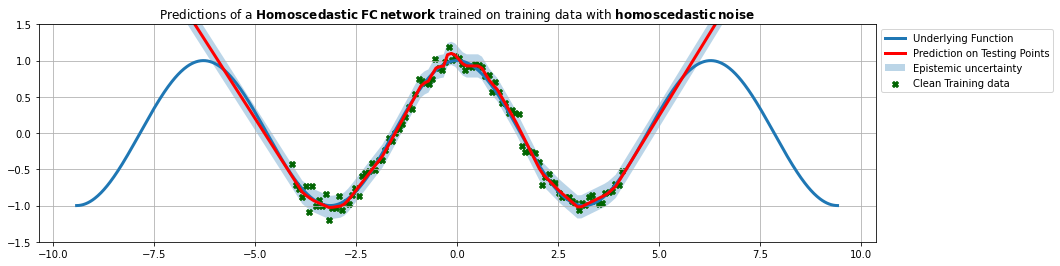

In [ ]:
# assume one scalar for the fixed standard dev of the likelihood's Gaussian
sigma_param = jnp.array(jnp.log(0.2))

# Initialize the network parameters that will produce the mean of the likelihood's Gaussian
params_homo_model_homo_data = standard_fc_network_init(input_dim, 
                                                       layers_width, 
                                                       output_dim, 
                                                       key)

# add the likelihood's Gaussian's standard dev to the list of parameters
params_homo_model_homo_data.append(sigma_param)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params_homo_model_homo_data)

params_homo_model_homo_data,\
train_loss_homo_model_homo_data,\
train_mse_homo_model_homo_data,\
test_mse_homo_model_homo_data = run_training_loop(num_epochs, 
                                                  opt_state, 
                                                  X_train,
                                                  Y_train_hom, 
                                                  X_test,
                                                  Y_test_true, 
                                                  len(layers_width)+1,
                                                  loss_mle_homoscedastic)

sigma_param = jnp.exp(params_homo_model_homo_data[-1])
print('The final trained homoscedastic standard deviation '
      'for data with fixed additive Gaussian noise is: ',
      sigma_param)

Y_test_pred_homo_model_homo_data = standard_fc_network_forward(X_test.T,
                                                               params_homo_model_homo_data[:-1])

visulize_predictions(Y_test_pred_homo_model_homo_data,
                     r'Predictions of a $\bf{Homoscedastic\, FC\, network}$'
                     r' trained on training data with $\bf{homoscedastic\, noise}$',
                     X_train,
                     Y_train_hom,
                     sigma_param)


Now, let us try it on the data with variable (heteroscedastic) label noise.

Starting loss:  6.8462796  Starting mse:  0.60294235
Epoch 1 | T: 0.001265 | Train loss: 6.624 | Train mse: 0.596 | Test mse: 0.503
Epoch 201 | T: 0.000504 | Train loss: -0.418 | Train mse: 0.016 | Test mse: 0.698
Epoch 401 | T: 0.000503 | Train loss: -0.641 | Train mse: 0.014 | Test mse: 1.391
Epoch 601 | T: 0.000505 | Train loss: -0.789 | Train mse: 0.012 | Test mse: 1.676
Epoch 801 | T: 0.000576 | Train loss: -0.826 | Train mse: 0.011 | Test mse: 2.027
The final trained homoscedastic standard deviation for data with variable (heteroscedastic) noise is:  0.10357546


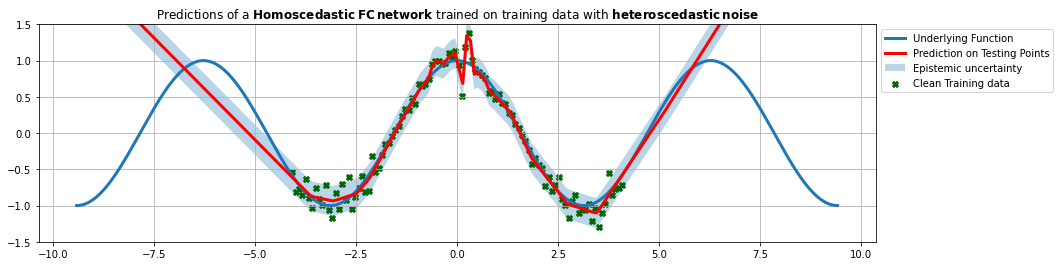

In [ ]:
# assume one scalar for the fixed standard dev of the likelihood's Gaussian
sigma_param = jnp.array(jnp.log(0.2))

# Initialize the network parameters that will produce the mean of the likelihood's Gaussian
params_homo_model_het_data = standard_fc_network_init(input_dim, 
                                                      layers_width,
                                                      output_dim, 
                                                      key)

# add the likelihood's Gaussian's standard dev to the list of parameters
params_homo_model_het_data.append(sigma_param)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params_homo_model_het_data)

params_homo_model_het_data,\
train_loss_homo_model_het_data,\
train_mse_homo_model_het_data,\
test_mse_homo_model_het_data = run_training_loop(num_epochs, 
                                                 opt_state,
                                                 X_train,
                                                 Y_train_het,
                                                 X_test,
                                                 Y_test_true,
                                                 len(layers_width)+1, 
                                                 loss_mle_homoscedastic)

sigma_param = jnp.exp(params_homo_model_het_data[-1])
print('The final trained homoscedastic standard deviation '
      'for data with variable (heteroscedastic) noise is: ',
      sigma_param)

Y_test_pred_homo_model_het_data = standard_fc_network_forward(X_test.T, params_homo_model_het_data[:-1])

visulize_predictions(Y_test_pred_homo_model_het_data,
                     r'Predictions of a $\bf{Homoscedastic\, FC\, network}$'
                     r' trained on training data with $\bf{heteroscedastic\, noise}$',
                     X_train, 
                     Y_train_het, 
                     sigma_param)


**Note.** A working implementation of the loss function should learn to put lower aleatoric uncertainty on the clean training data than the noisy ones.

# Variational Inference for Deep Regression Networks
In this practical we are interested in epistemic uncertainty estimation with deep networks based on the following paper.

[1] Blundell et al., "Weight Uncertainty in Neural Networks", ICML 2015

---



In order to model epistemic uncertainty, we can use Bayesian modelling to obtain a posterior distribution on model parameters:

\begin{align}
P(\mathbf{\theta}|\mathcal{D})= \frac{P(\mathcal{D}|\mathbf{\theta})P(\mathbf{\theta})}{P(\mathcal{D})}
\end{align}



Using this posterior distribution, we can transfer the uncertainty in model parameters to uncertainty in predictive distribution, for a new test sample $\mathbf{x}$:

\begin{align}
  P(y|\mathbf{x},\mathcal{D})=\int P(y|\mathbf{x},\mathbf{\theta})P(\mathbf{\theta}|\mathcal{D})d\theta.
\end{align}

However, obtaining $P(\mathbf{\theta}|\mathcal{D})$ can be problematic due to the interactability of calculating $P(\mathcal{D})$. Thus there are several techniques developed to approximate the posterior distribution $P(\mathbf{\theta}|\mathcal{D})$. One of these techniques is called Variational Inference (VI). In VI, we seek to identify another, simpler, distribution $Q_\omega(\theta)$, parametrized by $\omega$, that approximates $P(\theta|\mathcal{D})$. In VI we can maximize the variational lower bound (ELBO)(or minimize a negated version) as follows (details provided in the course lectures and the VAE practical):


\begin{align}
\omega^*=\text{argmin}_{\omega} -\mathbb{E}_{Q_\omega(\theta)}[\log P(\mathcal{D}|\theta)]+\text{D}_{\text{KL}}(Q_\omega(\theta)||P(\theta))
\end{align}


Assuming i.i.d. dataset $\mathcal{D}$ we will have:

\begin{align}
\omega^*=\text{argmin}_{\omega} -\mathbb{E}_{Q_\omega(\theta)}[\sum^{n}_{i=1}\log P(y|\mathbf{x},\theta)]+\text{D}_{\text{KL}}(Q_\omega(\theta)||P(\theta))
\end{align}

Using monte-carlo estimation of the expecation with $S$ samples we get:

\begin{align}
\omega^*=\text{argmin}_{\omega} -\frac{1}{S}\sum_{s=1}^{S}\sum^{n}_{i=1}\log P(y|\mathbf{x},\theta_s)+\text{D}_{\text{KL}}(Q_\omega(\theta)||P(\theta)), \tag{2}
\end{align}

where, $\{\theta_s\}_{s=1}^{S}\sim Q_\omega(\theta)$.

Let us consider the following distributions:

*   $P(\theta)=\mathcal{N}(\mathbf{0}_p, a^2\mathbf{I}_p)\qquad\qquad\qquad\;\;$ with $\;a^2=10^{-4}$
*   $Q_{\omega=(\mu,\sigma^2)}(\theta)=\mathcal{N}(\mathbf{\mu}, diag(\mathbf{\sigma}^2))\qquad$ with $\;\mu \in \mathbb{R}^{p}\;$ and $\;\sigma^2 \in \mathbb{R}_{+}^{p}$
*   $P(y|\mathbf{x},\theta)=\mathcal{N}(f_{\theta}^{\mu}(\mathbf{x}), f_{\theta}^{\sigma^2}(\mathbf{x})) \qquad\;$ with $\;f_{\theta}^{\mu}(\mathbf{x}) \in \mathbb{R}\;$ and $\;f_{\theta}^{\sigma^2}(\mathbf{x}) \in \mathbb{R}_{+}$


where $f_\theta$ denotes the VI deep network's function. $f_{\theta}^{\mu}(\mathbf{x})$ and $f_{\theta}^{\sigma^2}(\mathbf{x})$ denote the mean and variance outputs repsectively from the deep network for an input $\mathbf{x}$. Note that $P(\theta)$ and $Q_{\omega}(\theta)$ have a diagonal covariance matrix.

Following [1], to avoid numerical issues, in the implementation we will have the deep network to output $f_{\theta}^{\rho}(\mathbf{x}))$ instead and we obtain the variance using the softplus operation as:

\begin{align}
  f_{\theta}^{\sigma}=\text{log}(1+\exp(f_{\theta}^{\rho})) 
\end{align}


Now, your job is to plug in the distributions above into the objective in equation 2 assuming a single-sample monte-carlo estimate ($S=1$). Note that the KL divergence of two Gaussians have a closed-from solution and the natural logarithm of a Gaussian gives away two simple terms and a constant. Fill in the following objective equation with your derived terms:


\begin{align}
\omega^*=\text{argmin}_{\omega} ...
\end{align}

**========================**
####**TODO**: Complete Equations.
**========================**

Furthermore, we saw in the class that backpropagating through a stochastic node is problematic. One simple remedy, among others [2], to this problem is called reparametrization trick. There, for a Gaussian distribution, one can sample from a fixed (non-learnable) standard distribution and then transfer the sample into a sample of the original distribution by


\begin{align}
  \theta_s= \sigma\otimes\epsilon + \mu \qquad \text{with }\; \epsilon \sim \mathcal{N}(\mathbf{0}_p, \mathbf{I}_p)
\end{align}

where $\otimes$ denotes an elementwise (Hadamard) product.

In the following, we consider a fixed aleatoric uncertainty where we set $f^{\sigma^2}_\hat{\theta}(\mathbf{x}_i)=c^2$ that means our likelihood function takes the form $P(y|\mathbf{x},\theta)=\mathcal{N}(f_{\theta}^{\mu}(\mathbf{x}), c^2)$. Next, you will need to implement the objective function that you derived above using $c^2=1$ and the reparametrization trick.

---
[1] Blundell et al., "Weight Uncertainty in Neural Networks", ICML 2015

[2] Bengio, et al., "Estimating or Propagating Gradients", 2013

In [ ]:
# VI network's configurations
input_dim = X_train.shape[1]
output_dim = Y_train_true.shape[1]
layers_width = [100, 20, 100]
kl_prior_mean = 0
kl_prior_sigma = 1e-2
kl_weight = 1e-4

In [ ]:
# Initialize the parameters of a VI-based fully-connected layer
def vi_fc_layer_init(input_dim, output_dim, key, scale=1e-2):
    keys = random.split(key, 2)
    weights_mean = random.normal(keys[0], (output_dim, input_dim)) * scale
    weights_rho = -2*jnp.ones((output_dim, input_dim))
    biases_mean  = random.normal(keys[1], (output_dim, 1)) * scale
    biases_rho = -2*jnp.ones((output_dim, 1))
    return weights_mean, weights_rho, biases_mean, biases_rho

In [ ]:
# Forward pass of a VI-based fully-connected layer
def vi_fc_layer_forward(input, weights_mean, weights_rho, biases_mean, biases_rho, key):
    """
        ==============================
        TODO: Implementation required.
        ==============================
        Implement the reparametrization trick:
        1. For weights and biases:
        1.1 Sample from a standard Gaussian distribution using random.normal
        1.2 Transform the sample into a sample of the desired Gaussian distribution
        2. Return the affine transformation of the input using the weights and biases
    """

    # raise NotImplementedError("Task: Implement!")
    weights = (nn.softplus(weights_rho) * random.normal(key, weights_mean.shape)) + weights_mean
    biases = (nn.softplus(biases_rho) * random.normal(key, biases_mean.shape)) + biases_mean
    output = jnp.dot(weights, input) + biases
    return output

In [ ]:
# Initialize a VI-based fully-connected network 
def vi_fc_network_init(input_dim, layers_width, output_dim, key):
  network_feature_dims = [input_dim, *layers_width, output_dim]
  keys = random.split(key, len(network_feature_dims[:-1]))
  params = [vi_fc_layer_init(network_feature_dims[i],
                             network_feature_dims[i+1], 
                             keys[i]) 
            for i in range(len(network_feature_dims[:-1]))]
  return params

In [ ]:
# Forward pass of a VI-based fully-connected network 
def vi_fc_network_forward(input, params, key, is_classification=False):

    representation = input
    keys = random.split(key, len(params))

    for (weights_mean, weights_rho, biases_mean, biases_rho), key in zip(params[:-1], keys[:-1]):
        representation = nn.relu(vi_fc_layer_forward(representation, weights_mean, weights_rho, biases_mean, biases_rho, key))
    representation = vi_fc_layer_forward(representation, params[-1][0], params[-1][1], params[-1][2], params[-1][3], keys[-1]) 
    
    return representation

In [ ]:
params = vi_fc_network_init(input_dim, 
                            layers_width,
                            output_dim, 
                            key)

In [ ]:
def kl_divergence_two_diagonal_gaussians(q_mu, q_sigma, p_mu, p_sigma):        
    """
    calculates the KL-divergence of two diagnoal gaussians.
    For convenience, p_mu and p_sigma can be scalars.
    """
    q_mu = q_mu.flatten()
    q_sigma = q_sigma.flatten()

    N = q_mu.shape[0]

    p_sigma *= p_sigma
    q_sigma *= q_sigma

    if jnp.isscalar(p_mu):
        p_mu = p_mu * jnp.ones_like(q_mu) 
        p_sigma = p_sigma * jnp.ones_like(q_mu)
    else:
        p_mu = p_mu.flatten()
        p_sigma = p_sigma.flatten()


    p_mu = p_mu.reshape(N)
    q_mu = q_mu.reshape(N)
    p_sigma = p_sigma.reshape(N)
    q_sigma = q_sigma.reshape(N)

    ip_sigma = 1/p_sigma
    diff = p_mu - q_mu

    tr_term   = jnp.sum(ip_sigma * q_sigma)
    det_term  = jnp.sum(jnp.log(p_sigma/q_sigma))
    quad_term = diff.T @ jnp.diag(1/p_sigma) @ diff 

    return .5 * (tr_term + det_term + quad_term - N) 

In [ ]:
def vi_loss(params, X, Y, prior_mu, prior_sigma, kl_weight, key, is_classification=False):
    """
    ==============================
    TODO: Implementation required.
    ==============================
    Implement the VI loss function you derived in the instructions
    1. Either use the provided implementation of the KL divergence of two Gaussians in kl_divergence_two_diagnoal_gaussians or implement one
    2. Complete the loss function calculation below
    3. For better learning use kl_weight as a coefficient to downweigh the KL term (prior), i.e., - expected_likelihood_term + kl_wieght*kl_prior_term  
    """
    preds = vi_fc_network_forward(X, params, key)

    # raise NotImplementedError("Task: Implement!")
    keys = random.split(key, len(params))
    kl_prior_term = 0
    # mu_matrix = []
    # rho_matrix = []
    # for (weights_mean, weights_rho, biases_mean, biases_rho), key in zip(params, keys):
    #   mu_matrix.append(weights_mean.flatten())
    #   mu_matrix.append(biases_mean.flatten())
    #   rho_matrix.append(weights_rho.flatten())
    #   rho_matrix.append(biases_rho.flatten())
    # mu = jnp.concatenate(mu_matrix)
    # rho = jnp.concatenate(rho_matrix)
    # sigma = nn.softplus(rho) 
    # kl_prior_term = kl_divergence_two_diagonal_gaussians(mu, rho, prior_mu, prior_sigma)
    # kl_prior_term = kl_divergence_two_diagonal_gaussians(params[0][0], params[0][1], prior_mu, prior_sigma)
    for i in range(0, len(params)):
        kl_prior_term += kl_divergence_two_diagonal_gaussians(params[i][0], nn.softplus(params[i][1]), prior_mu, prior_sigma)
        kl_prior_term += kl_divergence_two_diagonal_gaussians(params[i][2], nn.softplus(params[i][3]), prior_mu, prior_sigma)
    kl_prior_term /= len(params)
    expected_likelihood_term = ((preds - Y) ** 2).sum()
    total_loss = ( expected_likelihood_term) + (kl_weight*kl_prior_term)

    return total_loss 

In [ ]:
# Compute the gradient for a batch and update the parameters
@jit
def update(params, X, Y, opt_state, key):
    value, grads = value_and_grad(vi_loss)(params, 
                                           X, 
                                           Y,
                                           kl_prior_mean, 
                                           kl_prior_sigma, 
                                           kl_weight, 
                                           key)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Defining an optimizer in Jax
step_size = 1e-2
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

num_epochs = 1000

In [ ]:
# Implements a learning loop over epochs. 
def run_training_loop(num_epochs, opt_state, X, Y, X_test, Y_test):
    # Initialize placeholder for logging
    train_loss, test_loss = [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    keys = random.split(key)

    # Get initial accuracy after random init
    train_loss.append(vi_loss(params,
                              X.T, 
                              Y.T, 
                              kl_prior_mean,
                              kl_prior_sigma,
                              kl_weight, 
                              keys[0]))
    test_loss.append(vi_loss(params, 
                             X_test.T,
                             Y_test.T,
                             kl_prior_mean, 
                             kl_prior_sigma,
                             kl_weight,
                             keys[1]))

    keys = random.split(key, num_epochs*2)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        params, opt_state, loss_val = update(params, 
                                             X.T, 
                                             Y.T,
                                             opt_state,
                                             keys[epoch*2])
        train_loss.append(loss_val)

        epoch_time = time.time() - start_time
        test_loss.append(vi_loss(params,
                                 X_test.T,
                                 Y_test.T,
                                 kl_prior_mean,
                                 kl_prior_sigma,
                                 kl_weight, 
                                 keys[epoch*2+1]))
        if epoch%100 == 0:
            print("Epoch {} | T: {:0.6f} | Train loss: {:0.3f}"
                    " | Test loss: {:0.3f}".format(epoch+1, 
                                               epoch_time,
                                               train_loss[-1], 
                                               test_loss[-1]))

    return params, train_loss, test_loss

In [ ]:
def visualize_VI(params, X_train, Y_train, plot_title, num_trials = 10):
  
    Y_test_pred_list = []

    keys = random.split(key, num_trials)

    for i in tqdm.tqdm(range(num_trials)):
        Y_test_pred = vi_fc_network_forward(X_test.T, params, keys[i])
        Y_test_pred_list.append(Y_test_pred)
        
    Y_test_preds = np.concatenate(Y_test_pred_list, axis=0)

    Y_test_pred_mean = np.mean(Y_test_preds, axis=0)
    Y_test_pred_sigma = np.std(Y_test_preds, axis=0)
    visulize_predictions(Y_test_pred_mean,
                        plot_title,
                        X_train,
                        Y_train,
                        Y_test_pred_sigma)

Epoch 1 | T: 3.194694 | Train loss: 61.511 | Test loss: 110.896
Epoch 101 | T: 0.001459 | Train loss: 27.436 | Test loss: 134.081
Epoch 201 | T: 0.001528 | Train loss: 22.986 | Test loss: 192.027
Epoch 301 | T: 0.001625 | Train loss: 21.369 | Test loss: 222.713
Epoch 401 | T: 0.001450 | Train loss: 11.927 | Test loss: 974.058
Epoch 501 | T: 0.001687 | Train loss: 16.784 | Test loss: 398.581
Epoch 601 | T: 0.001651 | Train loss: 13.169 | Test loss: 299.108
Epoch 701 | T: 0.001385 | Train loss: 9.917 | Test loss: 172.194
Epoch 801 | T: 0.001523 | Train loss: 12.728 | Test loss: 413.831
Epoch 901 | T: 0.001566 | Train loss: 13.058 | Test loss: 167.262


100%|██████████| 10/10 [00:00<00:00, 100.83it/s]


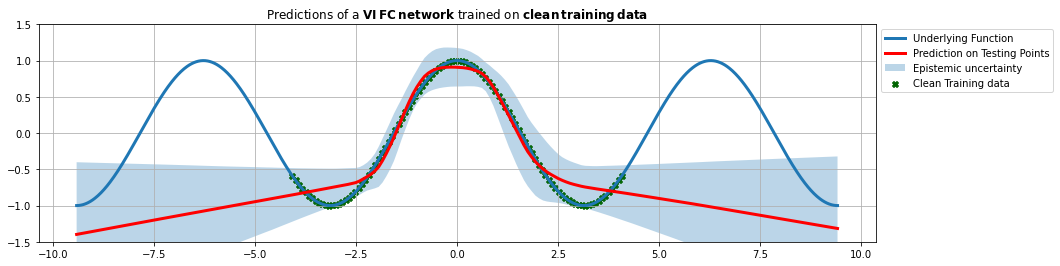

In [ ]:

params,\
train_loss,\
test_loss = run_training_loop(num_epochs,
                              opt_state, 
                              X_train,
                              Y_train_true, 
                              X_test,
                              Y_test_true)
visualize_VI(params,
             X_train, 
             Y_train_true, 
             r'Predictions of a $\bf{VI\, FC\, network}$'
             r' trained on $\bf{clean\, training\, data}$', 
             num_trials = 10)

Epoch 1 | T: 0.001580 | Train loss: 63.377 | Test loss: 110.897
Epoch 101 | T: 0.001551 | Train loss: 38.190 | Test loss: 167.795
Epoch 201 | T: 0.002148 | Train loss: 23.140 | Test loss: 256.800
Epoch 301 | T: 0.001466 | Train loss: 21.093 | Test loss: 271.538
Epoch 401 | T: 0.001463 | Train loss: 16.071 | Test loss: 525.970
Epoch 501 | T: 0.001603 | Train loss: 14.470 | Test loss: 462.174
Epoch 601 | T: 0.001485 | Train loss: 12.248 | Test loss: 445.171
Epoch 701 | T: 0.001434 | Train loss: 16.179 | Test loss: 145.117
Epoch 801 | T: 0.001612 | Train loss: 11.331 | Test loss: 218.106
Epoch 901 | T: 0.001336 | Train loss: 18.982 | Test loss: 171.565


100%|██████████| 10/10 [00:00<00:00, 100.81it/s]


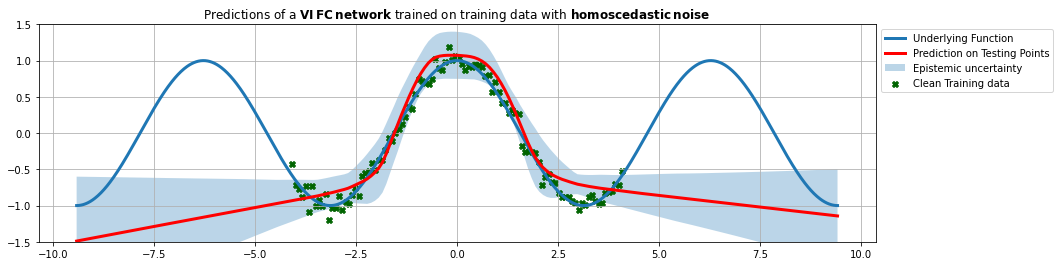

In [ ]:
params,\
train_loss,\
test_loss = run_training_loop(num_epochs,
                              opt_state, 
                              X_train, 
                              Y_train_hom,
                              X_test,
                              Y_test_true)
visualize_VI(params,
             X_train,
             Y_train_hom,
             r'Predictions of a $\bf{VI\, FC\, network}$'
             r' trained on training data with $\bf{homoscedastic\, noise}$',
             num_trials = 10)

Epoch 1 | T: 0.001473 | Train loss: 66.244 | Test loss: 110.828
Epoch 101 | T: 0.001277 | Train loss: 38.350 | Test loss: 140.556
Epoch 201 | T: 0.001305 | Train loss: 17.095 | Test loss: 374.140
Epoch 301 | T: 0.001302 | Train loss: 20.730 | Test loss: 180.776
Epoch 401 | T: 0.001342 | Train loss: 18.617 | Test loss: 1362.036
Epoch 501 | T: 0.001280 | Train loss: 16.576 | Test loss: 798.851
Epoch 601 | T: 0.001431 | Train loss: 13.994 | Test loss: 485.959
Epoch 701 | T: 0.001411 | Train loss: 11.685 | Test loss: 287.970
Epoch 801 | T: 0.001362 | Train loss: 10.792 | Test loss: 369.883
Epoch 901 | T: 0.001392 | Train loss: 10.413 | Test loss: 280.963


100%|██████████| 10/10 [00:00<00:00, 93.32it/s]


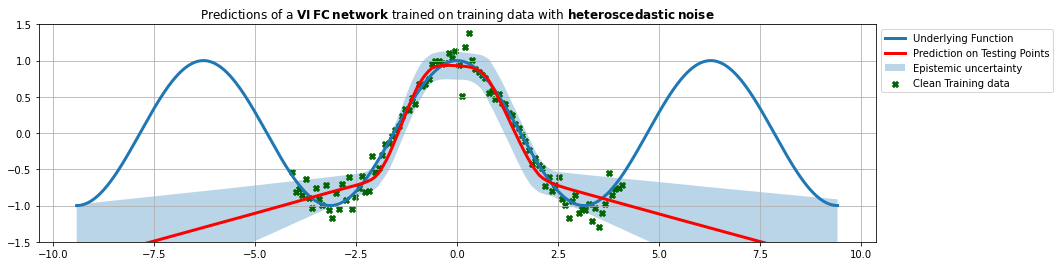

In [ ]:
params,\
train_loss,\
test_loss = run_training_loop(num_epochs,
                              opt_state, 
                              X_train, 
                              Y_train_het,
                              X_test,
                              Y_test_true)
visualize_VI(params,
             X_train,
             Y_train_het,
             r'Predictions of a $\bf{VI\, FC\, network}$'
             r' trained on training data with $\bf{heteroscedastic\, noise}$',
             num_trials = 10)

**Note.** A proper implementation would show growing uncertainty as we move away from the training region.

Finally, it is valuable for us to know how long did it take you to complete this practical?

around 7 hours